# Space Flight Mice Liver Gene Analysis
## Heat Propagation and Clustering Package
### Python 3 compatible version

----------------------

Author: Mikayla Webster (13webstermj@gmail.com)

Date: 19th May, 2018

----------------------

<a id='toc'></a>
## Table of Contents
1. [Background](#background)
2. [Import packages](#import)
3. [Define Analysis Preferences](#pref)
3. [Load Networks](#load)
4. [Localization](#local)
4. [Run Heat Propagation](#heat)
5. [Clustering](#cluster)
6. [Annotation](#annotation)
6. [Write to File](#write)

## Background
<a id='background'></a>

The Heat3 module provides tools to conduct an integrated network analysis of a set of differentially expressed genes (DEGs). The set of DEGs analyzed in this notebook come from an experiment performed by NASA called the [Rodent Research Project on the ISS](https://genelab-data.ndc.nasa.gov/genelab/accession/GLDS-48). The tissues sampled for this experiment were taken from the livers of mice who experienced space flight. 

The focus of this notebook is to show all available tools in the Heat Propogation and Clustering workflow (python 3 version), which includes an additional feature: annotation of clusters.

In [3]:
import sys
code_path = '../../network_bio_toolkit'
sys.path.append(code_path)

import importlib
import Heat3
importlib.reload(Heat3)

<module 'Heat3' from '../../network_bio_toolkit\\Heat3.py'>

In [4]:
symbol = 'symbol'
entrez = 'entrez'

human = 'human'
mouse = 'mouse'

heat = Heat3.Heat(gene_type = symbol, species = mouse)

In [5]:
filename = '../../background_networks/10090.protein.links.v10.5.txt'
heat.load_STRING_links(filename, confidence_filter = 700)

print('\nNumber of interactions: ' + str(len(list(heat.DG_universe.edges()))))

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-13911...done.
Finished.
70 input query terms found dup hits:
	[('ENSMUSP00000103671', 2), ('ENSMUSP00000087485', 2), ('ENSMUSP00000000574', 2), ('ENSMUSP000001267
410 input query terms found no hit:
	['ENSMUSP00000044573', 'ENSMUSP00000023462', 'ENSMUSP00000137380', 'ENSMUSP00000077813', 'ENSMUSP000
Pass "returnall=True" to return complete lists of duplicate or missing query terms.

Number of interactions: 368640


In [6]:
# for testing purposes only. Not necessary for analysis.
saved_DG_universe = heat.DG_universe
heat.DG_universe = saved_DG_universe

In [7]:
# load DEG file
DEG_filename = '../../DEG_databases/DE_CoeffspaceFlight - groundControl_glds48_20180312.csv'  
heat.create_DEG_list(DEG_filename, p_value_filter = 0.02, sep = ',')

print('Number of DEG\'s: ' + str(len(heat.DEG_list)))

Number of DEG's: 45


../../network_bio_toolkit\create_graph.py:366: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  df = pd.DataFrame.from_csv(filename, sep = sep)


## Localization 
<a id='local'></a>

C:\Users\m1web\Anaconda2\envs\ipykernel_py3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


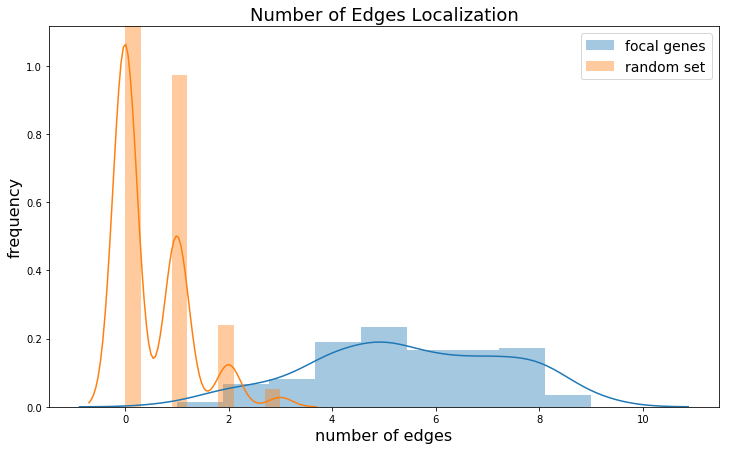

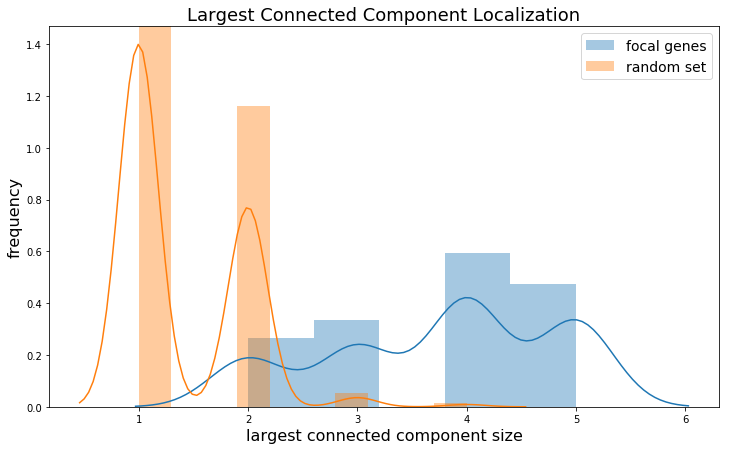

In [8]:
numedges_list, numedges_rand, LCC_list, LCC_rand = heat.localization(num_reps = 250, 
                                                                     sample_frac = 0.8, 
                                                                     method = 'both', 
                                                                     plot = True)

1.7065722168752018e-08


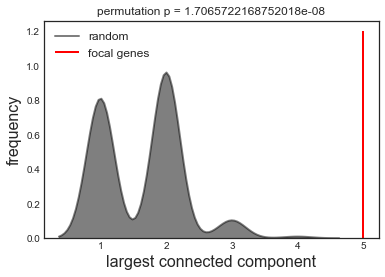

In [9]:
# test out plotting parameters with a smaller num_reps first.
numedges_list, numedges_rand, LCC_list, LCC_rand = heat.localization_full(num_reps = 200, 
                                                                          method = 'LCC', 
                                                                          label = 'focal genes',
                                                                          line_height = 1.2,
                                                                          legend_loc = 'upper left')

## Run Heat Propagation
<a id='heat'></a>

In [10]:
heat.normalized_adj_matrix()

In [11]:
# for testing purposes only. Not necessary for analysis. 
saved_Wprime = heat.Wprime
heat.Wprime = saved_Wprime

In [12]:
heat.draw_heat_prop(num_nodes = 500,
#                  random_walk = False,
                  edge_width = 2,
                  edge_smooth_enabled = True,
                  edge_smooth_type = 'bezier',
                  node_size_multiplier = 5,
                  hover = False,
                  hover_connected_edges = False,
                  largest_connected_component = True,
                  physics_enabled = True,
                  node_font_size = 40,
                  graph_id = 1,
                  node_shadow_x = 6)

## Clustering 
<a id='cluster'></a>

In [13]:
heat.draw_clustering(rad_positions = False,
                k = None,
                largest_connected_component = True,
                num_top_genes = 500,
                cluster_size_cut_off = 5,
                remove_stray_nodes = True,
                node_spacing = 700,
                node_size_multiplier = 10,
                physics_enabled = True,
                node_font_size = 40,
                graph_id = 2,
                edge_width = 2,
                edge_smooth_enabled = True,
                edge_smooth_type = 'bezier',
                hover = False,
                hover_connected_edges = False
               )

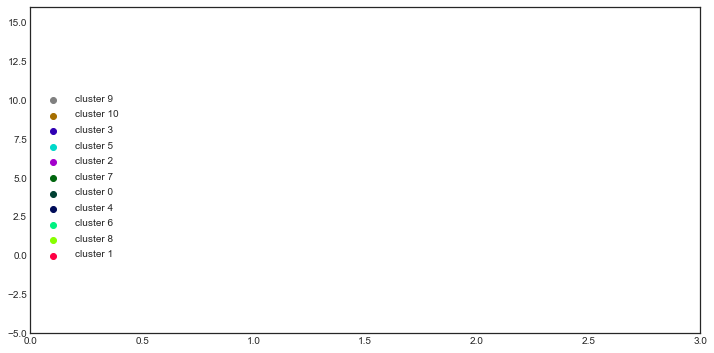

In [14]:
heat.cluster_legend(cluster_size_cut_off = 5)

In [15]:
heat.draw_clustering(num_top_genes = 500,
                cluster_size_cut_off = 5,
                remove_stray_nodes = True,
                r = 0.4,
                node_spacing = 600,
                node_size_multiplier = 4,
                physics_enabled = False,
                node_font_size = 15,
                graph_id = 3,
                node_shadow_x = 6,
                largest_connected_component = True,
                color_lfc = True,
                vmin = -1,
                vmax = 1
               )

## Annotation
<a id='annotation'></a>

In [16]:
heat.draw_clustering_with_annotation(graph_id = 4,
                        num_nodes = 500,
                        annotation = True,
                        node_spacing = 700,
                        node_size_multiplier = 5,
                        physics_enabled = False,
                        node_font_size = 20,
                        color_lfc = True,
                        vmin = -1,
                        vmax = 1,
                        node_size = 7)

Annotating cluster 0 of 10...
Annotating cluster 1 of 10...
Annotating cluster 2 of 10...
Annotating cluster 3 of 10...
Annotating cluster 4 of 10...
Annotating cluster 5 of 10...
Annotating cluster 6 of 10...
Annotating cluster 7 of 10...
Annotating cluster 8 of 10...
Annotating cluster 9 of 10...
Annotating cluster 10 of 10...
Done!


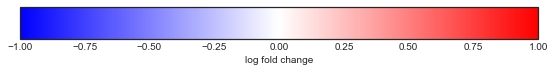

In [17]:
heat.draw_legend(vmin = -1, vmax = 1, label = 'log fold change')

## Write to File
<a id='write'></a>

In [18]:
heat.write_cluster_table('cluster_table_3.csv')